# Digit Classification from MNIST Dataset.

Creating a feed forward neural network for digit classification from the famous MNIST dataset. Also adding GPU support.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

# hyper parameters
input_size = 784  # mnist has 28x28 images, which after flattening becomes 784
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001


In [ ]:
# Importing MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True, transform=transforms.ToTensor())

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                           download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


We can see from the shape that our samples has a shape of 100x1x28x28, 100 being the batch size. We also see that our labels are in a 1-D array.

We may need to first flatten our samples into an array of 100x784.

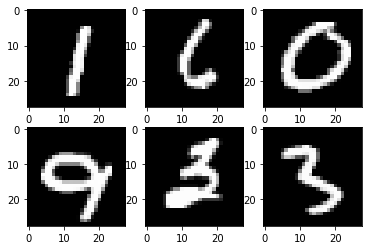

In [6]:
for i in range(6):
  plt.subplot(2, 3, i+1)  # creating a grid with 2 rows and 3 cols
  plt.imshow(samples[i][0], cmap='gray')  # plotting images with color map = gray
  plt.show  # display

In [7]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    return out

model = NeuralNet(input_size, hidden_size, num_classes)

We're not using softmax here because we'll be using cross entropy as our loss and PyTorch's cross entropy applies softmax to it's inputs, so doing that manually would be to apply softmax twice, which makes training slow.

In [8]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# training loop
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # backward pass
    optimizer.zero_grad() # setting the gradients to zero
    loss.backward() # backpropagation
    optimizer.step()  # optimizing our parameters

    if (i+1)%100 == 0:
      print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

epoch 1 / 2, step 100/600, loss = 0.6006
epoch 1 / 2, step 200/600, loss = 0.3164
epoch 1 / 2, step 300/600, loss = 0.2374
epoch 1 / 2, step 400/600, loss = 0.2946
epoch 1 / 2, step 500/600, loss = 0.2658
epoch 1 / 2, step 600/600, loss = 0.2804
epoch 2 / 2, step 100/600, loss = 0.2954
epoch 2 / 2, step 200/600, loss = 0.1722
epoch 2 / 2, step 300/600, loss = 0.1573
epoch 2 / 2, step 400/600, loss = 0.3093
epoch 2 / 2, step 500/600, loss = 0.2837
epoch 2 / 2, step 600/600, loss = 0.1303


In [11]:
# testing -
with torch.no_grad():
  n_correct = 0
  n_samples = 0

  for images, labels in test_loader:
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)
    # returns value, index. We only need index i.e the class label
    _, predictions = torch.max(outputs, 1)  # returns the index having the highest value.
    n_samples += labels.shape[0]  # Gives us number of samples in current batch (should be 100)
    n_correct += (predictions == labels).sum().item() # adding 1 for every correct prediction.

  acc = 100 * n_correct / n_samples
  print(f'accuracy = {acc}')

accuracy = 95.06
